In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [12]:
# Import our own modules
import utils
import model
import visualize
from model_predict_ast import check_accuracy as check_accuracy_test

In [3]:
DATA_SETS_MAP = {
    'synth':"../syntheticDetailed/naive_c5_q50_s4000_v0.csv",
    'code_org' : "../data/hoc_1-9_binary_input.csv"
}

DATA_SET = 'code_org'
# DATA_SZ = 500000
# DATA_SET = 'synth'

# if DATA_SZ = -1, use entire data set
DATA_SZ = 50000
# DATA_SZ = -1

In [4]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(DATA_SETS_MAP[DATA_SET],"rb"),delimiter=','))).astype('int')
if DATA_SZ != -1:
    data_array = data_array[:DATA_SZ]
    
np.random.shuffle(data_array)
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 

# Split data into train and test (half and half)

train_data = data_array[0:7*num_samples/8,:]
val_data =  data_array[7*num_samples/8: 15*num_samples/16 ,:]
test_data = data_array[15*num_samples/16:num_samples,:]

In [5]:
# code to see how many percent is correct
print (num_problems)
# for prob in xrange(num_problems):
#     print ('Train Prob {} : percent correct {}'.format(prob, np.mean(train_data[:,prob]) ))
#     print ('Val Prob {} : percent correct {}'.format(prob, np.mean(val_data[:,prob]) ))
#     print ('Test Prob {} : percent correct {}'.format(prob, np.mean(test_data[:,prob]) ))
print ('Total : percent correct {}'.format( np.mean(np.concatenate((np.concatenate((train_data, val_data), axis=0),test_data), axis=0 ))))
print ('Train : percent correct {}'.format( np.mean(train_data) ))
print ('Val : percent correct {}'.format( np.mean(val_data) ))
print ('Test : percent correct {}'.format( np.mean(test_data) ))


9
Total : percent correct 0.848597777778
Train : percent correct 0.848246349206
Val : percent correct 0.85344
Test : percent correct 0.848675555556


In [6]:
num_train = train_data.shape[0]
num_test = test_data.shape[0]

print('Vectorization...')
X_train, next_problem_train, truth_train = utils.vectorize_data(train_data)
X_val, next_problem_val, truth_val = utils.vectorize_data(val_data)
X_test, next_problem_test, truth_test = utils.vectorize_data(test_data)

train_data = utils.vectorize_data(train_data)
val_data = utils.vectorize_data(val_data)
test_data = utils.vectorize_data(test_data)

print ("Vectorization done!")
print X_train.shape
print X_val.shape
print X_test.shape

Vectorization...
Vectorization done!
(43750, 8, 18)
(3125, 8, 18)
(3125, 8, 18)


In [7]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 1.0
reg_strength = 0.0
grad_clip = 10
batchsize = 32
num_epochs = 20
dropout_p = 0.2
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [8]:
# create model
train_acc_fn, compute_cost_acc = model.create_model(num_timesteps, num_problems, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Computing updates ...
Compiling functions ...
Compiling done!


In [9]:
# Training!!!
train_losses, train_accuracies, val_accuracies = model.train(train_data, val_data, train_acc_fn, compute_cost_acc,  num_epochs=num_epochs, batchsize=batchsize)

Starting training...
  Epoch 0 	batch 1 	loss 0.692711924532 	train acc 55.47 	val acc 84.74 
  Epoch 0 	batch 2 	loss 0.66166702992 	train acc 87.89 	val acc 84.12 
  Epoch 0 	batch 3 	loss 0.594960823161 	train acc 89.06 	val acc 84.12 
  Epoch 0 	batch 4 	loss 0.528741404715 	train acc 84.38 	val acc 83.53 
  Epoch 0 	batch 5 	loss 0.42989550624 	train acc 85.55 	val acc 83.53 
  Epoch 0 	batch 6 	loss 0.481319036594 	train acc 81.64 	val acc 84.13 
  Epoch 0 	batch 7 	loss 0.500252607888 	train acc 81.64 	val acc 84.12 
  Epoch 0 	batch 8 	loss 0.329539698545 	train acc 87.11 	val acc 84.12 
  Epoch 0 	batch 9 	loss 0.2958024405 	train acc 87.89 	val acc 84.11 
  Epoch 0 	batch 10 	loss 0.431619133597 	train acc 82.81 	val acc 84.38 
  Epoch 0 	batch 11 	loss 0.509055742964 	train acc 80.08 	val acc 83.64 
  Epoch 0 	batch 12 	loss 0.567967028671 	train acc 76.56 	val acc 83.60 
  Epoch 0 	batch 13 	loss 0.375962710651 	train acc 83.98 	val acc 84.36 
  Epoch 0 	batch 14 	loss 0.35

KeyboardInterrupt: 

In [15]:
# model.check_accuracy(train_data, compute_cost_acc, dataset_name='train')
X_test, next_problem_test, truth_test = train_data
check_accuracy_test((X_test, truth_test), compute_cost_acc, dataset_name='train')

Testing...


TypeError: ('Bad input argument to theano function with name "model.py:107"  at index 1(0-based)', 'Wrong number of dimensions: expected 3, got 2 with shape (43750, 8).')

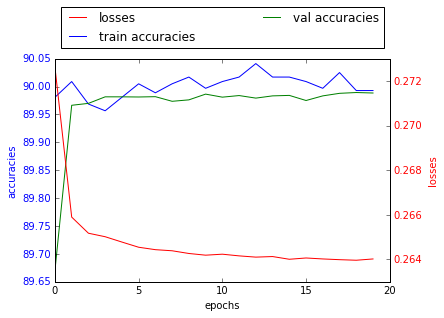

In [14]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
visualize.plot_loss_acc(DATA_SET + '_train', train_losses, val_accuracies, train_accuracies, learning_rate, reg_strength, num_epochs, num_train)

In [ ]:
# More runs, do k fold validation

In [ ]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 1.0
reg_strength = 0.0
grad_clip = 10
batchsize = 32
num_epochs = 20
dropout_p = 0.2
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'